In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit 
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from  sklearn.metrics import recall_score
from scipy import stats
import warnings
warnings.filterwarnings(action='once')
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  roc_curve
from sklearn.ensemble import  RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.20.3


In [4]:
data=pd.read_csv("apush.csv")

In [5]:
data.reset_index(drop=True,inplace=True)

In [6]:
data.head()

,brand,date,id_val,model,price,year,Color,Body_Style,Horsepower,Hand_Drive,Engine_Cylinders,Engine,Engine_Volume,Interior_Color,Mileage,Gearbox,Drive_train,sold
0,Opel,8/2/2018,ID: 1770041,Astra,3000.0,2003,black,Hatchback,NaN,Left,NaN,Petrol,NaN,NaN,140000.0,Mechanical,NaN,No
1,Toyota,8/2/2018,ID: 1769874,Camry,9310.0,2012,black,Sedan,NaN,Left,NaN,Petrol,NaN,NaN,102000.0,Automatic,NaN,Yes
2,Nissan,8/2/2018,ID: 1769860,Elgrand,6982.5,2006,White,Minivan / Minibus,NaN,Right,NaN,Petrol,NaN,NaN,75000.0,Automatic,NaN,Yes
3,Mitsubishi,8/2/2018,ID: 1770897,Pajero,7913.5,2007,black,Truck:,NaN,Left,NaN,Astragalus,NaN,NaN,136000.0,Automatic,NaN,Yes
4,Mazda,8/2/2018,ID: 1770715,6,11637.5,2015,Grey,Sedan,NaN,Left,NaN,Petrol,NaN,NaN,89000.0,Automatic,NaN,Yes


In [7]:

data.drop(columns=data.columns[data.isna().any()].tolist(),inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62658 entries, 0 to 62657
Data columns (total 13 columns):
brand         62658 non-null object
date          62658 non-null object
id_val        62658 non-null object
model         62658 non-null object
price         62658 non-null float64
year          62658 non-null int64
Color         62658 non-null object
Body_Style    62658 non-null object
Hand_Drive    62658 non-null object
Engine        62658 non-null object
Mileage       62658 non-null float64
Gearbox       62658 non-null object
sold          62658 non-null object
dtypes: float64(2), int64(1), object(10)
memory usage: 6.2+ MB


In [8]:
data.drop(columns=["id_val","date"],inplace=True)

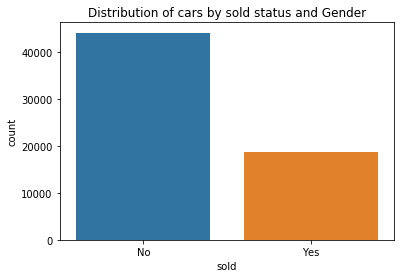

No     70.331003
Yes    29.668997
Name: sold, dtype: float64


In [9]:
 # as it is unnecessary data

sns.countplot(x="sold",data=data)
plt.title("Distribution of cars by sold status and Gender")
plt.show()
#let's see percenatage of customers who didn't subscribe to term deposit,
#and percenatage of customers who subscribed to term deposit
print(data.sold.value_counts()/len(data)*100)

#### <p1>as we see our benchmark is about 84 percent our model should predict more precisely</p1>

df_num=data.select_dtypes(exclude="object")## we divide data in this groups to check variance, 
df_object=data.select_dtypes(include="object")#if there is exict a column containing only one value
for i in df_num:
    if df_num[i].var()==0:
        del df_num[i]
cols_should_dropped=[i for i in df_object.columns if len(df_object[i].unique())==1]
df_object=df_object.drop(columns=cols_should_dropped)

## Plot the boxplots and Histograms for all numeric variables 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


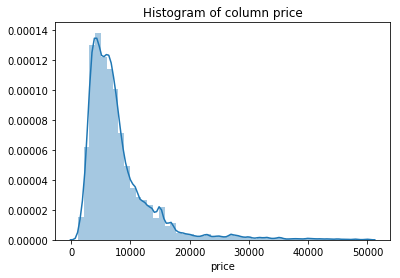

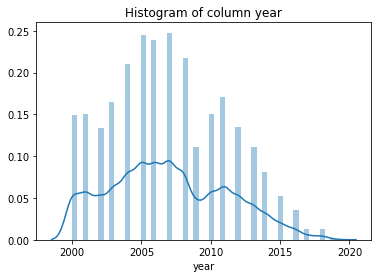

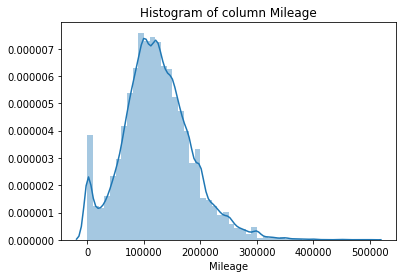

In [9]:
for i in df_num:
        sns.distplot(df_num[i],norm_hist=True)
        plt.title("Histogram of column %s"% i)
        plt.show()

<p>It seemed only age was normally distributed</p>

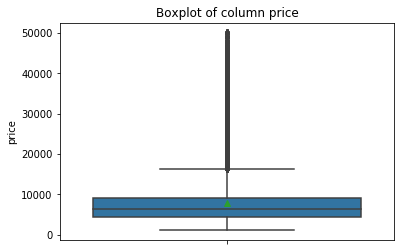

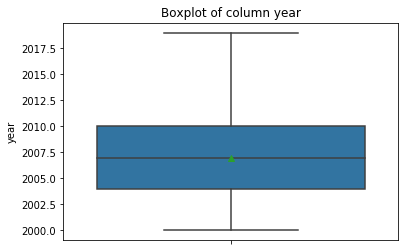

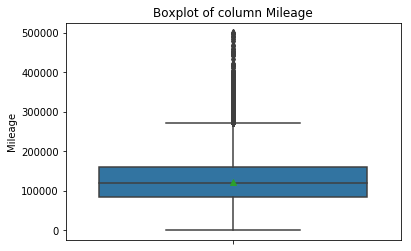

In [22]:
for i in df_num:
    sns.boxplot(data=df_num,y=i,showmeans=True,fliersize=5)
    plt.title("Boxplot of column %s"% i)
    plt.show()


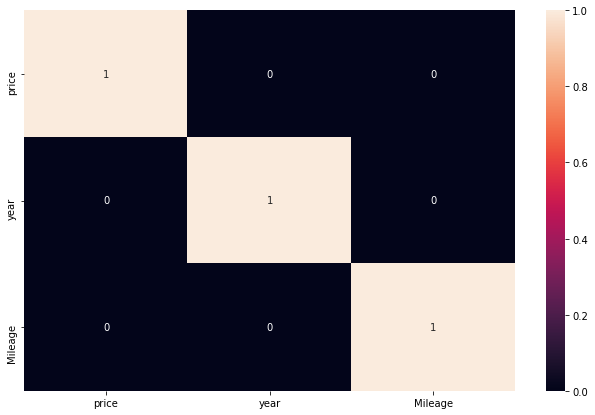

In [23]:
plt.figure(figsize=(11,7))
sns.heatmap(df_num.corr().abs().round(2)>0.7,annot=True)
plt.show()

<h4>As we see we have highly correlated variabe monthly income and job level I will drop joblevel to keep variables independet</h4>

# Logit 1- With data with outliers and joblevel

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62658 entries, 0 to 62657
Data columns (total 11 columns):
brand         62658 non-null object
model         62658 non-null object
price         62658 non-null float64
year          62658 non-null int64
Color         62658 non-null object
Body_Style    62658 non-null object
Hand_Drive    62658 non-null object
Engine        62658 non-null object
Mileage       62658 non-null float64
Gearbox       62658 non-null object
sold          62658 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 5.3+ MB


In [10]:
### lets create dummies from object variables and final data
df_dummies=pd.get_dummies(df_object,prefix=df_object.columns,drop_first=True)
data1=df_num.join(df_dummies)
Y1=data1.sold_Yes
X1=data1.drop("sold_Yes",axis=1)
grid1=GridSearchCV(LogisticRegression(solver='liblinear',random_state=42,class_weight="balanced"),param_grid={"C":np.linspace(0.0001,1,20),"penalty":
                                                                                                ["l1","l2"]},scoring="roc_auc",cv=5,n_jobs=-1)


In [11]:
#grid1.fit(X1,Y1)
#params=list(grid1.best_params_.values())
#C,Penalty=params
#x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.2,random_state=42,stratify=Y1)
#logit1=LogisticRegression(random_state=42,C=C,penalty=Penalty,class_weight='balanced').fit(x_train,y_train)
train_score=logit1.score(x_train,y_train)
test_score=logit1.score(x_test,y_test)
print(grid1.best_params_)
print("Train score is %s and Test score is%s"%(train_score,test_score))
print("cross_validation score is %s"% (np.mean(cross_val_score(LogisticRegression(random_state=42,C=C,penalty=Penalty,class_weight='balanced'),X1,Y1,cv=5))))
y_pred=logit1.predict(x_test)
y_pred2=logit1.predict(x_train)
print(classification_report(y_test,logit1.predict(x_test)))
print("roc_auc: for test is",roc_auc_score(y_test,y_pred))
print("roc_auc: for train is",roc_auc_score(y_train,y_pred2))
print("average Roc_score is",grid1.best_score_)
print("recall for train",recall_score(y_train,y_pred2))
print("recall for test",recall_score(y_test,y_pred))

NameError: name 'logit1' is not defined

In [ ]:
data.columns

In [250]:
z=data[:1]
z.drop(columns="sold",inplace=True)
#z["price"]=2000
df_num=z.select_dtypes(exclude="object")## we divide data in this groups to check variance, 
df_object=z.select_dtypes(include="object")
df_dummies=pd.get_dummies(df_object,prefix=df_object.columns,drop_first=False)
new=df_num.join(df_dummies)#if there is exict a column containing only one value

print(new)
#new["price"]=0

for i in X1.columns:
    if i not in new.columns:
        new[i]=0
new

for i in new.columns:
    if i not in X1.columns:
        del new[i]

grid1.predict_proba(new)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
import pandas as pd
data=pd.read_csv("final.csv")

In [1]:
from joblib import dump, load
dump(grid1, 'logit.joblib') 
clf = load('filename.joblib')

NameError: name 'grid1' is not defined

In [3]:
clf = load('logit.joblib')

C:\Users\Vazgen\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Vazgen\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.20.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
clf.predict()

In [7]:
data=data[:1]

In [11]:
df_num=data.select_dtypes(exclude="object")## we divide data in this groups to check variance, 
df_object=data.select_dtypes(include="object")#if there is exict a column containing only one value
df_dummies=pd.get_dummies(df_object,prefix=df_object.columns,drop_first=False)
new=df_num.join(df_dummies)
new

,price,year,Horsepower,Engine_Cylinders,Engine_Volume,Mileage,brand_Opel,model_Astra,Color_black,Body_Style_Hatchback,Hand_Drive_Left,Engine_Petrol,Gearbox_Mechanical,sold_No
0,3000.0,2003,NaN,NaN,NaN,140000.0,1,1,1,1,1,1,1,1


In [19]:
#ROC curve
FPR,TPR,tresholds=roc_curve(y_test,tree.predict_proba(x_test)[:,1])
plt.plot(FPR,TPR,label="ROC AUC=%f"%roc_auc_score(y_test,y_pred))
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

NameError: name 'tree' is not defined

## From the result we can say that our data cleaning did  positive affect on model, it increase recall and roc score, but however it is still bias and did not reach benchmark.


# Decision tree
<h3>For decision tree we do not have to drop correlated variables so lets add them to corrected_dataframe

In [44]:
data3=df_num.join(df_dummies)##corrected dataframe is different from corrected1 it include correleted variables
Y3=data3.sold_Yes
X3=data3.drop("sold_Yes",axis=1)
grid3=GridSearchCV(DecisionTreeClassifier(random_state=42,class_weight="balanced"),
             param_grid={"max_depth":range(10,30),
                         "min_samples_leaf":range(40,60,10),
                         },scoring="roc_auc",cv=5,n_jobs=-1).fit(X3,Y3)
params=list(grid3.best_params_.values())
depth,leafs=params
x_train,x_test,y_train,y_test=train_test_split(X3,Y3,test_size=0.2,random_state=42,stratify=Y3)
tree=DecisionTreeClassifier(random_state=42,class_weight="balanced",max_depth=depth,min_samples_leaf=leafs).fit(x_train,y_train)
train_score=tree.score(x_train,y_train)
test_score=tree.score(x_test,y_test)
print(grid3.best_params_)
print("Train score is %s and Test score is%s"%(train_score,test_score))
print("cross_validation score is %s"% (np.mean(cross_val_score(DecisionTreeClassifier(random_state=42,class_weight="balanced",max_depth=depth,min_samples_leaf=leafs),X3,Y3,cv=5))))
y_pred=tree.predict(x_test)
y_pred2=tree.predict(x_train)
print(classification_report(y_test,tree.predict(x_test)))
print("roc_auc: for test is",roc_auc_score(y_test,y_pred))
print("roc_auc: for train is",roc_auc_score(y_train,y_pred2))
print("average Roc_score is",grid3.best_score_)
print("recall for train",recall_score(y_train,y_pred2))
print("recall for test",recall_score(y_test,y_pred))

{'max_depth': 22, 'min_samples_leaf': 50}
Train score is 0.6359972868371704 and Test score is0.5884934567507182
cross_validation score is 0.5894054879233049
              precision    recall  f1-score   support

           0       0.78      0.58      0.67      8814
           1       0.38      0.60      0.46      3718

   micro avg       0.59      0.59      0.59     12532
   macro avg       0.58      0.59      0.57     12532
weighted avg       0.66      0.59      0.61     12532

roc_auc: for test is 0.592068641592127
roc_auc: for train is 0.6495733334507222
average Roc_score is 0.6305677577273717
recall for train 0.682961269499731
recall for test 0.6008606777837547


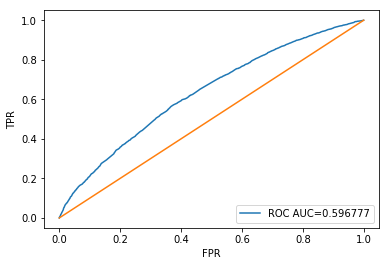

In [39]:
#ROC curve
FPR,TPR,tresholds=roc_curve(y_test,tree.predict_proba(x_test)[:,1])
plt.plot(FPR,TPR,label="ROC AUC=%f"%roc_auc_score(y_test,y_pred))
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [32]:
data4=corrected1.join(df_object)
data4.Attrition=data4.Attrition.apply(lambda x:1 if x=="Yes" else 0 )
#let's get formula for logistic regression
formula="Attrition~"+"+".join(data4.drop("Attrition",axis=1).columns)
logit1=Logit.from_formula(formula=formula,data=data4).fit()
logit1.summary()

         Current function value: 0.294841
         Iterations: 35


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1427
Method:                           MLE   Df Model:                           42
Date:                Mon, 26 Nov 2018   Pseudo R-squ.:                  0.3325
Time:                        16:00:24   Log-Likelihood:                -433.42
converged:                      False   LL-Null:                       -649.29
                                        LLR p-value:                 3.860e-66
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              -11.9297   1193.658     -0.010      0.992   -2351.456    2327.597
BusinessTravel[T.Travel_Frequently]      1.8964      0.413      4.596      0.000       1.088       2.705
BusinessTravel[T.Travel_Rarely]          1.0033      0.380      2.640      0.008       0.258       1.748
Department[T.Research & Development]    13.7624   1193.657      0.012      0.991   -2325.762    2353.287
Department[T.Sales]                     13.6448   1193.657      0.011      0.991   -2325.880    2353.170
EducationField[T.Life Sciences]         -0.7292      0.800     -0.911      0.362      -2.297       0.839
EducationField[T.Marketing]             -0.3465      0.849     -0.408      0.683      -2.010       1.317
EducationField[T.Medical]               -0.7918      0.800     -0.990      0.322      -2.360       0.777
EducationField[T.Other]                 -0.8720      0.860     -1.013      0.311      -2.559       0.815
EducationField[T.Technical Degree]       0.1332      0.818      0.163      0.871      -1.470       1.737
Gender[T.Male]                           0.4108      0.184      2.231      0.026       0.050       0.772
JobRole[T.Human Resources]              15.1622   1193.657      0.013      0.990   -2324.363    2354.687
JobRole[T.Laboratory Technician]         1.5644      0.471      3.323      0.001       0.642       2.487
JobRole[T.Manager]                       0.3168      0.869      0.365      0.715      -1.386       2.019
JobRole[T.Manufacturing Director]        0.1438      0.533      0.270      0.787      -0.900       1.188
JobRole[T.Research Director]            -1.1078      0.948     -1.169      0.242      -2.965       0.750
JobRole[T.Research Scientist]            0.6635      0.477      1.391      0.164      -0.271       1.598
JobRole[T.Sales Executive]               1.1004      1.121      0.982      0.326      -1.096       3.297
JobRole[T.Sales Representative]          2.1879      1.164      1.880      0.060      -0.093       4.469
MaritalStatus[T.Married]                 0.2643      0.265      0.998      0.318      -0.255       0.784
MaritalStatus[T.Single]                  1.0913      0.343      3.186      0.001       0.420       1.763
OverTime[T.Yes]                          1.9807      0.193     10.255      0.000       1.602       2.359
Age                                     -0.0291      0.013     -2.175      0.030      -0.055      -0.003
DailyRate                               -0.0003      0.000     -1.340      0.180      -0.001       0.000
DistanceFromHome                         0.0444      0.011      4.153      0.000       0.023       0.065
Education                                0.0085      0.087      0.097      0.923      -0.163       0.180
EnvironmentSatisfaction                 -0.4271      0.082     -5.188      0.000      -0.588      -0.266
HourlyRate                               0.0016      0.004      0.358      0.721      -0.00

In [33]:
log_summary=pd.read_html(logit1.summary().tables[1].as_html(),header=0)[0]
log_summary[log_summary["P>|z|"]<0.05]##here are vairables that are signidicant that affect an employee churn 
# if we state alpha 0.05

C:\Users\user\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


,Unnamed: 0,coef,std err,z,P>|z|,[0.025,0.975]
1,BusinessTravel[T.Travel_Frequently],1.8964,0.413,4.596,0.000,1.088,2.705
2,BusinessTravel[T.Travel_Rarely],1.0033,0.380,2.640,0.008,0.258,1.748
10,Gender[T.Male],0.4108,0.184,2.231,0.026,0.050,0.772
12,JobRole[T.Laboratory Technician],1.5644,0.471,3.323,0.001,0.642,2.487
20,MaritalStatus[T.Single],1.0913,0.343,3.186,0.001,0.420,1.763
21,OverTime[T.Yes],1.9807,0.193,10.255,0.000,1.602,2.359
22,Age,-0.0291,0.013,-2.175,0.030,-0.055,-0.003
24,DistanceFromHome,0.0444,0.011,4.153,0.000,0.023,0.065
26,EnvironmentSatisfaction,-0.4271,0.082,-5.188,0.000,-0.588,-0.266
28,JobInvolvement,-0.5497,0.122,-4.517,0.000,-0.788,-0.311


In [34]:
#we should calculate marginal effects to be able to interpret change of y variable
logit1.get_margeff().summary()
log_summary=pd.read_html(logit1.get_margeff().summary().tables[1].as_html(),header=0)[0]
log_summary=log_summary.rename(columns={"Unnamed: 0":"Parameter"})##making summary as dataframe to manipulate easily
log_summary[log_summary["P>|z|"]<0.05]

,Parameter,dy/dx,std err,z,P>|z|,[0.025,0.975]
0,BusinessTravel[T.Travel_Frequently],0.1714,0.036,4.695,0.000,0.100,0.243
1,BusinessTravel[T.Travel_Rarely],0.0907,0.034,2.657,0.008,0.024,0.158
9,Gender[T.Male],0.0371,0.017,2.243,0.025,0.005,0.070
11,JobRole[T.Laboratory Technician],0.1414,0.042,3.363,0.001,0.059,0.224
19,MaritalStatus[T.Single],0.0986,0.031,3.225,0.001,0.039,0.159
20,OverTime[T.Yes],0.1790,0.015,11.787,0.000,0.149,0.209
21,Age,-0.0026,0.001,-2.188,0.029,-0.005,-0.000
23,DistanceFromHome,0.0040,0.001,4.230,0.000,0.002,0.006
25,EnvironmentSatisfaction,-0.0386,0.007,-5.357,0.000,-0.053,-0.024
27,JobInvolvement,-0.0497,0.011,-4.640,0.000,-0.071,-0.029


 If p<=0.05,then there is a statistically significant relationship between affairs and corresponding variable.
 
Interpreting for continuous variable. So, incremental  incraese in age will decrease the likelihood(probability) of being in Attrition group on average by 5%(0.0026*100%) if other factors held constant.

For categgorical variables we say for example,being a male will increase probability of  being in Attrition group compared to females on on average by 5%(0.0371*100%) if other factors held constant.


In [35]:
importances=tree.feature_importances_
importances=pd.DataFrame(data=importances, index=X3.columns, columns=['importances']).sort_values(by=['importances'],ascending=False)
importances[:12]

,importances
OverTime_Yes,0.308649
TotalWorkingYears,0.153284
JobLevel,0.125901
MonthlyIncome,0.082056
JobRole_Sales Executive,0.075464
StockOptionLevel,0.062805
JobSatisfaction,0.052906
YearsInCurrentRole,0.038450
Age,0.024675
TrainingTimesLastYear,0.023994


Here are important features for decision tree classifier

In [46]:
data3=df_num.join(df_dummies)##corrected dataframe is different from corrected1 it include correleted variables
Y3=data3.sold_Yes
X3=data3.drop("sold_Yes",axis=1)
grid4=GridSearchCV(RandomForestClassifier(random_state=42,class_weight="balanced"),
             param_grid={"max_depth":range(10,30),
                         "min_samples_leaf":range(40,50,10),
                       "n_estimators":range(2,5)  },scoring="roc_auc",cv=5,n_jobs=-1).fit(X3,Y3)
params=list(grid4.best_params_.values())
depth,leafs,n_estimators=params
x_train,x_test,y_train,y_test=train_test_split(X3,Y3,test_size=0.2,random_state=42,stratify=Y3)
forest=RandomForestClassifier(random_state=42,class_weight="balanced",max_depth=depth,min_samples_leaf=leafs,n_estimators=n_estimators).fit(x_train,y_train)
train_score=forest.score(x_train,y_train)
test_score=forest.score(x_test,y_test)
print(grid4.best_params_)
print("Train score is %s and Test score is%s"%(train_score,test_score))
print("cross_validation score is %s"% (np.mean(cross_val_score(RandomForestClassifier(random_state=42,class_weight="balanced",max_depth=depth,min_samples_leaf=leafs,n_estimators=n_estimators),X3,Y3,cv=5))))
y_pred=forest.predict(x_test)
y_pred2=forest.predict(x_train)
print(classification_report(y_test,forest.predict(x_test)))
print("roc_auc: for test is",roc_auc_score(y_test,y_pred))
print("roc_auc: for train is",roc_auc_score(y_train,y_pred2))
print("average Roc_score is",grid4.best_score_)
print("recall for train",recall_score(y_train,y_pred2))
print("recall for test",recall_score(y_test,y_pred))

{'max_depth': 28, 'min_samples_leaf': 40, 'n_estimators': 4}
Train score is 0.5736743406615329 and Test score is0.5751675710181934
cross_validation score is 0.5766215546695392
              precision    recall  f1-score   support

           0       0.80      0.53      0.64      8814
           1       0.38      0.68      0.49      3718

   micro avg       0.58      0.58      0.58     12532
   macro avg       0.59      0.61      0.56     12532
weighted avg       0.67      0.58      0.59     12532

roc_auc: for test is 0.6063874858973566
roc_auc: for train is 0.6052468670229447
average Roc_score is 0.6330316266708871
recall for train 0.6828940290478752
recall for test 0.6831629908552985


In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train,y_pred2)

0.5736743406615329

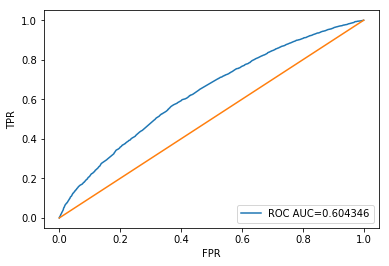

In [41]:
#ROC curve
FPR,TPR,tresholds=roc_curve(y_test,tree.predict_proba(x_test)[:,1])
plt.plot(FPR,TPR,label="ROC AUC=%f"%roc_auc_score(y_test,y_pred))
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [60]:
data.Gearbox.unique()

array(['Mechanical', 'Automatic', 'Robot', 'Variator:'], dtype=object)

In [58]:
data.Engine.unique()

array(['Petrol', 'Astragalus', 'Diesel', 'Hybrid:', 'Electricity'],
      dtype=object)

In [88]:
data2=[{"brand":"Lexus","model":"RX 350 ","price":20000,"year":2011,"Color":"White","Hand_Drive":"Left","Engine":"Astragalus",
            "Mileage":100000,"Gearbox":"Automatic"}]
z=pd.DataFrame(data2)

,Color,Engine,Gearbox,Hand_Drive,Mileage,brand,model,price,year
0,White,Astragalus,Automatic,Left,100000,Lexus,RX 350,20000,2011


In [99]:
np.set_printoptions(suppress=True)
np.linspace(0.0001,1,25)

array([0.0001   , 0.0417625, 0.083425 , 0.1250875, 0.16675  , 0.2084125,
       0.250075 , 0.2917375, 0.3334   , 0.3750625, 0.416725 , 0.4583875,
       0.50005  , 0.5417125, 0.583375 , 0.6250375, 0.6667   , 0.7083625,
       0.750025 , 0.7916875, 0.83335  , 0.8750125, 0.916675 , 0.9583375,
       1.       ])